In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung_xray_classifier/pytorch/default/1/lung_xray_classify.pth
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1563.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_854.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1404.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1194.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1772.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_934.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1461.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_60.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_296.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1011.png
/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1254.png
/kagg

In [2]:
# Basic PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Utility
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy


In [3]:
import os
import shutil
import random

def split_dataset(input_dir, output_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    classes = os.listdir(input_dir)
    
    for cls in classes:
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue  

        images = os.listdir(cls_path)
        random.shuffle(images)

        split_idx = int(len(images) * train_ratio)
        train_imgs = images[:split_idx]
        test_imgs = images[split_idx:]

       
        train_cls_dir = os.path.join(output_dir, "train", cls)
        test_cls_dir = os.path.join(output_dir, "test", cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        os.makedirs(test_cls_dir, exist_ok=True)

        
        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))
        for img in test_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

    print(" Dataset split completed!")

split_dataset("/kaggle/input/covid-pneumonia-normal-chest-xray-images", "/kaggle/working/", train_ratio=0.8)


 Dataset split completed!


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import os


train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),              
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomRotation(15),                   
    transforms.ColorJitter(                          
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_data = datasets.ImageFolder('/kaggle/working/train', transform=train_transforms)
test_data = datasets.ImageFolder('/kaggle/working/test', transform=test_transforms)

train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")


Training samples: 4181
Testing samples: 1047


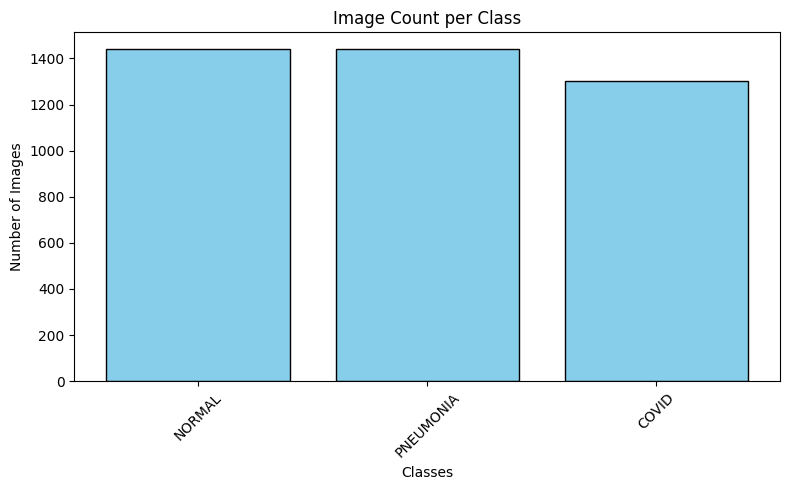

In [5]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(data_dir):

    
    class_counts = {}
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] = num_images

   
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Image Count per Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution("/kaggle/working/train")




In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

lr = 8.083031267478023e-05

dropout = 0.3006558931441291
num_epochs = 10

model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(dropout),
    nn.Linear(model.fc.in_features, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, "Adam")(model.parameters(), lr=lr, weight_decay=1e-4)


train_losses, val_losses = [], []
train_accs, val_accs = [], []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0

    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_data_loader.dataset)
    epoch_acc = correct / total

    model.eval()
    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_epoch_loss = test_loss / len(test_data_loader.dataset)
    test_accuracy = correct / total

  
    train_losses.append(epoch_loss)
    val_losses.append(test_epoch_loss)
    train_accs.append(epoch_acc)
    val_accs.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {test_epoch_loss:.4f}, Val Acc: {test_accuracy:.4f}")


torch.save({
    "epoch": num_epochs,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "loss": loss,
}, "checkpoint.pth")

torch.save(model.state_dict(), "lung_model.pth")

# epochs = range(1, num_epochs + 1)
# plt.figure(figsize=(12, 5))


# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, marker='o', label='Train Loss')
# plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
# plt.title('Training vs Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
# plt.plot(epochs, val_accs, marker='o', label='Validation Accuracy')
# plt.title('Training vs Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.4732, Train Acc: 0.8072 | Val Loss: 0.1828, Val Acc: 0.9351
Epoch [2/10] Train Loss: 0.3078, Train Acc: 0.8840 | Val Loss: 0.1159, Val Acc: 0.9599
Epoch [3/10] Train Loss: 0.2694, Train Acc: 0.9010 | Val Loss: 0.1444, Val Acc: 0.9589
Epoch [4/10] Train Loss: 0.2530, Train Acc: 0.9070 | Val Loss: 0.1041, Val Acc: 0.9685
Epoch [5/10] Train Loss: 0.2237, Train Acc: 0.9156 | Val Loss: 0.1114, Val Acc: 0.9647
Epoch [6/10] Train Loss: 0.2171, Train Acc: 0.9168 | Val Loss: 0.1243, Val Acc: 0.9589
Epoch [7/10] Train Loss: 0.2153, Train Acc: 0.9285 | Val Loss: 0.1372, Val Acc: 0.9522
Epoch [8/10] Train Loss: 0.1952, Train Acc: 0.9333 | Val Loss: 0.0847, Val Acc: 0.9742
Epoch [9/10] Train Loss: 0.1894, Train Acc: 0.9304 | Val Loss: 0.1121, Val Acc: 0.9647
Epoch [10/10] Train Loss: 0.2031, Train Acc: 0.9220 | Val Loss: 0.2028, Val Acc: 0.9427


Using device: cuda

=== Classification Report ===
              precision    recall  f1-score   support

       COVID       0.99      0.98      0.99       326
      NORMAL       0.87      1.00      0.93       361
   PNEUMONIA       1.00      0.86      0.92       360

    accuracy                           0.95      1047
   macro avg       0.95      0.95      0.95      1047
weighted avg       0.95      0.95      0.95      1047



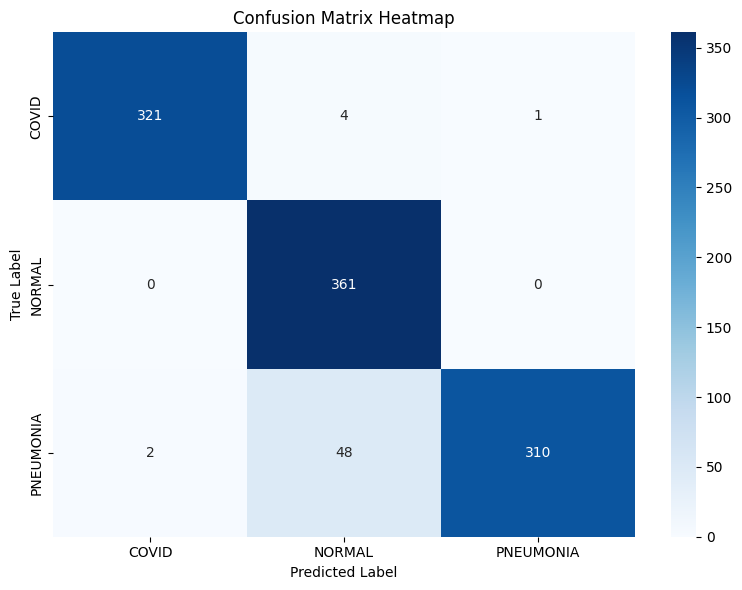

In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model_path="/kaggle/working/lung_model.pth", test_dir="/kaggle/working/test", batch_size=32):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    
    model = models.resnet18(pretrained=False)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, 3) 
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

   
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

   
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.tight_layout()
    plt.show()

evaluate_model("lung_model.pth", "/kaggle/working/test")


In [13]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

 Predicted Class: COVID


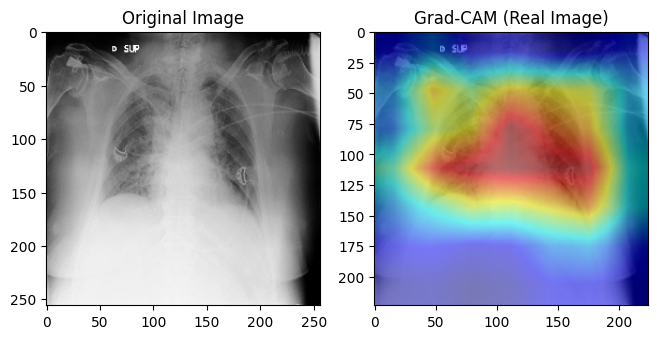

In [18]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


model  = model.to(device);

class_names = ['COVID', 'NORMAL', 'PNEUMONIA']


def get_edge_for_visualization(pil_img):
    w, h = pil_img.size
    scale = 256 / min(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = pil_img.resize((new_w, new_h), Image.BILINEAR)
    
    left = (resized.width - 224) // 2
    top = (resized.height - 224) // 2
    cropped = resized.crop((left, top, left + 224, top + 224))
    
    gray = cv2.cvtColor(np.array(cropped), cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = 255 - cv2.Canny(blurred, 30, 80)
    
    edge_rgb = np.stack([edges]*3, axis=-1).astype(np.float32) / 255.0
    return edge_rgb


def predict_and_visualize(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = data_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = class_names[pred_idx]

    print(f" Predicted Class: {pred_label}")


    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred_idx)]

    heatmap = cam(input_tensor=input_tensor, targets=targets)


    edge_img = get_edge_for_visualization(image)
    cam_edge = show_cam_on_image(edge_img, heatmap[0], use_rgb=True)

   
    img_arr = np.array(image).astype(np.float32) / 255
    img_arr = cv2.resize(img_arr, (224, 224))
    cam_real = show_cam_on_image(img_arr, heatmap[0], use_rgb=True)

    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_real)
    plt.title("Grad-CAM (Real Image)")



predict_and_visualize("/kaggle/input/covid-pneumonia-normal-chest-xray-images/COVID/COVID_100.png")


